In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import tensorflow as tf
import umap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lib.utils import load_data, split_data, create_tf_dataset
import os

print(f"tensorflow: {tf.__version__}")
print(f"keras: {tf.keras.__version__}")

tensorflow: 2.0.0-beta0
keras: 2.2.4-tf


In [3]:
%env DATA_DIR ../data/GSE92742_Broad_LINCS

data_dir = os.environ['DATA_DIR']

# data_fname = 'GSE92742_Broad_LINCS_Level4_ZSPCINF_mlr12k_n1319138x12328.gctx' # Level 4 data
data_fname = 'GSE92742_Broad_LINCS_Level3_INF_mlr12k_n1319138x12328.gctx' # Level 3 data
data_path = os.path.join(data_dir, data_fname)

sample_meta_fname = 'GSE92742_Broad_LINCS_inst_info.txt'
sample_meta_path = os.path.join(data_dir, sample_meta_fname)

env: DATA_DIR=../data/GSE92742_Broad_LINCS


In [4]:
# Read in raw data, selecting for cells by treatment and cell line

pert_types = [
    'trt_cp',       # treated with compound
    'ctl_vehicle',  # control for compound treatment (e.g DMSO) 
    'ctl_untrt'     # untreated samples
]

cell_ids = [
    'VCAP', # prostate tumor
    'MCF7', # breast tumor
    'PC3',  # prostate tumor
]

# Load Data
sample_meta, gene_labels, data = load_data(data_path, sample_meta_path, pert_types, cell_ids)

# Normalize expression between 0-1 per gene
# TODO: implement this normalization per batch during training
data_normed = data / data.max(0)

print(f"data size: {data.shape[0]:,}")
print(f"n_genes: {data.shape[1]}")

data size: 333,523
n_genes: 978


In [5]:
# Split data into training, validation, and testing
train, val, test = split_data(data_normed, sample_meta, 0.2)

print(f"training size:   {train[0].shape[0]:,}")
print(f"validation size: {val[0].shape[0]:,}")
print(f"testing size:    {test[0].shape[0]:,}")

training size:   213,454
validation size: 53,364
testing size:    66,705


In [6]:
batch_size = 64
train_dataset = create_tf_dataset(train[0].values, train[0].values, batch_size=batch_size)
train_dataset

<PrefetchDataset shapes: ((None, 978), (None, 978)), types: (tf.float32, tf.float32)>

In [7]:
# Tensorboard stuff
# import datetime, os
# logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
# tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

from lib.models import create_AE
tf.random.set_seed(42)
model = create_AE([128, 2, 128])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               125312    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               384       
_________________________________________________________________
dense_3 (Dense)              (None, 978)               126162    
Total params: 252,116
Trainable params: 252,116
Non-trainable params: 0
_________________________________________________________________


In [8]:
model.fit(
    train_dataset,
    epochs = 5,
    shuffle = True,
    steps_per_epoch = train[0].shape[0] // batch_size,
    validation_data = (val[0].values, val[0].values),
#     callbacks = [tensorboard_callback]
)

Epoch 1/5
3335/3335 [==============================] - 13s 4ms/step - loss: 0.1316 - cosine_similarity: 0.7931 - pearsons_corrcoef: 0.3068 - val_loss: 0.1063 - val_cosine_similarity: 0.8371 - val_pearsons_corrcoef: 0.3057
Epoch 2/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0854 - cosine_similarity: 0.8714 - pearsons_corrcoef: 0.3960 - val_loss: 0.0724 - val_cosine_similarity: 0.8922 - val_pearsons_corrcoef: 0.3902
Epoch 3/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0651 - cosine_similarity: 0.9037 - pearsons_corrcoef: 0.4306 - val_loss: 0.0565 - val_cosine_similarity: 0.9170 - val_pearsons_corrcoef: 0.4268
Epoch 4/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0513 - cosine_similarity: 0.9250 - pearsons_corrcoef: 0.4678 - val_loss: 0.0479 - val_cosine_similarity: 0.9302 - val_pearsons_corrcoef: 0.4760
Epoch 5/5
3335/3335 [==============================] - 11s 3ms/step - loss: 0.0445 - cosine_similarity: 0.9354 -

In [9]:
test_loss = model.evaluate(test[0].values, test[0].values)
print(f"loss: {test_loss}")

66705/66705 [==============================] - 3s 47us/sample - loss: 0.0409 - cosine_similarity: 0.9407 - pearsons_corrcoef: 0.5046
loss: [0.040947982598062344, 0.9406916, 0.5045911]


### Plotting

In [10]:
from lib.utils import plot_embedding2D, plot_embedding3D
encoder = tf.keras.Model(inputs=model.layers[0].input, outputs=model.layers[1].output)
h = encoder.predict(test[0])

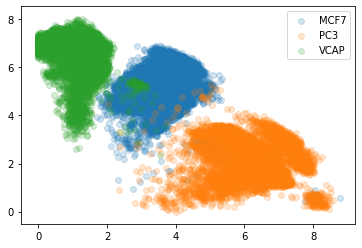

In [11]:
plot_embedding2D(h, test[1].cell_id.values, alpha=0.2)

### Inspect most activating samples

In [12]:
import altair as alt
alt.data_transformers.enable('data_server')

DataTransformerRegistry.enable('data_server')

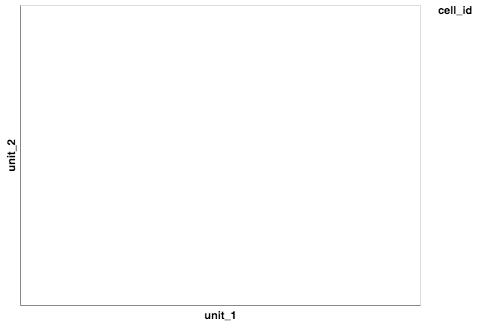

In [13]:
df = pd.DataFrame({
    'unit_1': h[:,0], 
    'unit_2': h[:,1],
    'cell_id': test[1].cell_id.values
})

alt.Chart(df).mark_circle(opacity=0.2).encode(
    x='unit_1:Q',
    y='unit_2:Q',
    color='cell_id:N'
)

### Cell-type meta data

In [14]:
cell_info_fname = 'GSE92742_Broad_LINCS_cell_info.txt'
cell_meta = pd.read_csv(os.path.join(data_dir, cell_info_fname), sep='\t', na_values = '-666')

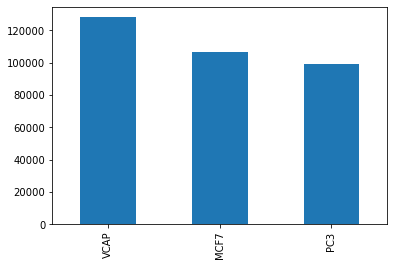

In [15]:
sample_counts = sample_meta['cell_id'].value_counts()
sample_counts[sample_counts > 5000].plot(kind='bar');

In [16]:
cell_meta[cell_meta.base_cell_id == 'PC3']

,cell_id,cell_type,base_cell_id,precursor_cell_id,modification,sample_type,primary_site,subtype,original_growth_pattern,provider_catalog_id,original_source_vendor,donor_age,donor_sex,donor_ethnicity
54,PC3,cell line,PC3,NaN,NaN,tumor,prostate,adenocarcinoma,mix,CRL-1435,ATCC,62.0,M,Caucasian
55,PC3.101,cell line,PC3,PC3,genetically modified to stably express Cas9 pr...,tumor,prostate,adenocarcinoma,mix,CRL-1435,ATCC,62.0,M,Caucasian
56,PC3.311,cell line,PC3,PC3,genetically modified to stably express Cas9 pr...,tumor,prostate,adenocarcinoma,mix,CRL-1435,ATCC,62.0,M,Caucasian
